In [3]:
import os
import pickle
import torch
import numpy as np
from torch.utils.data import DataLoader
import models, datasets, utils, trainers
from config_trAISformer import Config

# -------------- Konfiguracja ----------------
cf = Config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
init_seqlen = cf.init_seqlen
predict_steps = cf.max_seqlen + 1 - init_seqlen  # liczba kroków do przewidzenia
batch_size = cf.batch_size
moving_threshold = 0.05

In [7]:
last_path = "/home/machineblue/repositories/TrAISformer/results/004-baltic_small-pos-pos_vicinity-10-40-blur-True-False-2-1.0-data_size-720-1180-30-72-embd_size-512-512-128-128-head-8-8-bs-128-lr-0.0006-seqlen-12-120/best_model.pt"

In [8]:
# -------------- Przygotowanie danych testowych ----------------
print(f"Ładowanie danych testowych z {cf.datadir}/{cf.testset_name}...")
with open(os.path.join(cf.datadir, cf.testset_name), "rb") as f:
    raw = pickle.load(f)
# filtrujemy i tworzymy Dataset analogicznie jak w main.py
Data = [x for x in raw if not np.isnan(x["traj"]).any() and len(x["traj"]) > cf.min_seqlen]
# obcinamy trajektorie do momentu ruchu
for V in Data:
    moving = np.where(V["traj"][:,2] > moving_threshold)[0]
    if len(moving)>0:
        V["traj"] = V["traj"][moving[0]:]
# tworzymy AISDataset
test_ds = datasets.AISDataset(Data,
                              max_seqlen=cf.max_seqlen + 1,
                              device=device)
test_loader = DataLoader(test_ds,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=0)

# -------------- Wczytanie modelu ----------------
print("Inicjalizacja i wczytanie wag modelu...")
model = models.TrAISformer(cf, partition_model=None)
state = torch.load(last_path, map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()

Ładowanie danych testowych z ./data/baltic_small//baltic_small_test.pkl...
Inicjalizacja i wczytanie wag modelu...


TrAISformer(
  (blur_module): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=replicate)
  (lat_emb): Embedding(720, 512)
  (lon_emb): Embedding(1180, 512)
  (sog_emb): Embedding(30, 128)
  (cog_emb): Embedding(72, 128)
  (ctp_emb): Embedding(72, 128)
  (dtp_emb): Embedding(10, 128)
  (drop): Dropout(p=0.1, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (ln1): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
      (attn): CausalSelfAttention(
        (key): Linear(in_features=1536, out_features=1536, bias=True)
        (query): Linear(in_features=1536, out_features=1536, bias=True)
        (value): Linear(in_features=1536, out_features=1536, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (resid_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
      )
      (mlp): Sequential(
        (

In [9]:
# ile mamy próbek?
print("Liczba trajektorii:", len(Data))
# rozkład długości trajektorii
lengths = [len(V["traj"]) for V in Data]
print("Min/średnia/max długość:", min(lengths), np.mean(lengths), max(lengths))

Liczba trajektorii: 1866
Min/średnia/max długość: 6 92.62968917470525 120


In [10]:
for i, V in enumerate(Data[:3]):
    traj = V["traj"]
    print(f"\nPróbka {i}: kształt = {traj.shape}")
    print(traj[:5])         # pierwsze 5 wierszy
    print("…")
    print(traj[-5:])        # ostatnie 5 wierszy


Próbka 0: kształt = (96, 8)
[[2.49026329e-01 4.46182794e-01 9.65416667e-02 3.60590278e-01
  5.33355572e-01 4.00000000e-01 1.74549385e+09 5.63460000e+08]
 [2.49260945e-01 4.47747837e-01 1.66535433e-01 1.93919510e-01
  5.36387044e-01 4.00000000e-01 1.74549445e+09 5.63460000e+08]
 [2.50040671e-01 4.49780821e-01 1.80000000e-01 1.90777778e-01
  5.40001415e-01 4.00000000e-01 1.74549505e+09 5.63460000e+08]
 [2.50778595e-01 4.51857201e-01 1.79514825e-01 1.91262354e-01
  5.43604676e-01 4.00000000e-01 1.74549565e+09 5.63460000e+08]
 [2.51324591e-01 4.53631021e-01 1.06974494e-01 2.26223981e-01
  5.46641310e-01 4.00000000e-01 1.74549625e+09 5.63460000e+08]]
…
[[1.78782500e-01 4.33782797e-01 0.00000000e+00 6.74405864e-01
  6.94480966e-01 0.00000000e+00 1.74554845e+09 5.63460000e+08]
 [1.78782643e-01 4.33783305e-01 0.00000000e+00 9.98456790e-02
  6.94482318e-01 0.00000000e+00 1.74554905e+09 5.63460000e+08]
 [1.78783472e-01 4.33783029e-01 0.00000000e+00 7.32770062e-01
  6.94444844e-01 0.00000000e+00

In [11]:
from tqdm import tqdm

In [12]:
# -------------- Inferencja ----------------
max_samples = 10
all_preds = []
with torch.no_grad():
    for seqs, masks, seqlens, mmsis, time_starts in tqdm(test_loader, desc="Inference"):
        if len(all_preds) >= max_samples:
            break
        seqs_init = seqs[:, :init_seqlen, :].to(device)
        preds = trainers.sample(
            model=model,
            seqs=seqs_init,
            steps=predict_steps,
            temperature=1.0,
            sample=False,
            sample_mode=cf.sample_mode,
            r_vicinity=cf.r_vicinity,
            top_k=cf.top_k
        )
        all_preds.append(preds.cpu())

Inference:  67%|██████▋   | 10/15 [03:25<01:42, 20.50s/it]


In [48]:
Data[15]

{'mmsi': 244901000,
 'traj': array([[8.46390000e-01, 3.41696695e-01, 6.66666667e-02, 4.86111111e-01,
         6.24852578e-01, 8.00000000e-01, 1.74491922e+09, 2.44901000e+08],
        [8.46263178e-01, 3.41713037e-01, 1.75134168e-02, 4.72147684e-01,
         6.24870724e-01, 8.00000000e-01, 1.74491982e+09, 2.44901000e+08],
        [8.45379238e-01, 3.42291512e-01, 1.60166667e-01, 3.60095486e-01,
         6.25047903e-01, 8.00000000e-01, 1.74492042e+09, 2.44901000e+08],
        [8.43973514e-01, 3.44137450e-01, 2.26315789e-01, 4.46052632e-01,
         6.25430544e-01, 8.00000000e-01, 1.74492102e+09, 2.44901000e+08],
        [8.40731732e-01, 3.45014962e-01, 3.65445445e-01, 4.47655989e-01,
         6.25946501e-01, 8.00000000e-01, 1.74492162e+09, 2.44901000e+08],
        [8.37154315e-01, 3.45968454e-01, 2.65922330e-01, 4.53613808e-01,
         6.26516371e-01, 8.00000000e-01, 1.74492222e+09, 2.44901000e+08],
        [8.34428179e-01, 3.46762091e-01, 2.26435556e-01, 5.58896296e-01,
         6.269593

In [13]:
test_preds = torch.cat(all_preds, dim=0)

In [14]:
test_preds.size()

torch.Size([1280, 121, 6])

In [15]:
all_preds[0].size()

torch.Size([128, 121, 6])

In [16]:
test_preds = torch.cat(all_preds, dim=0)
print(f"Zrobiono inferencję na {len(test_preds)} sekwencjach.")
print(f"Kształt predykcji: {test_preds.shape}")
test_preds = test_preds.numpy()
test_preds = test_preds[:, init_seqlen:, :]  # obcinamy do przewidzianych kroków

Zrobiono inferencję na 1280 sekwencjach.
Kształt predykcji: torch.Size([1280, 121, 6])


In [ ]:
LAT_MIN = cf.lat_min
LAT_MAX = cf.lat_max
LON_MIN = cf.lon_min
LON_MAX = cf.lon_max


def denormalize_array(arr, LAT_MIN, LAT_MAX, LON_MIN, LON_MAX, SPEED_MAX):
    """
    Denormalizuje tablicę arr o kształcie (..., 4), gdzie:
      - arr[..., 0] to znormalizowane wartości lat ∈ [0,1]
      - arr[..., 1] to znormalizowane wartości lon ∈ [0,1]
      - arr[..., 2] to znormalizowane wartości sog (speed over ground) ∈ [0,1]
      - arr[..., 3] to znormalizowane wartości cog (course over ground) ∈ [0,1]

    Zwraca nową tablicę NumPy o tych samych kształtach, ale zdenormalizowaną:
      lat = lat * (LAT_MAX - LAT_MIN) + LAT_MIN
      lon = lon * (LON_MAX - LON_MIN) + LON_MIN
      sog = sog * SPEED_MAX
      cog = cog * 360.0
    """
    # zabezpieczamy, żeby nie nadpisać oryginału
    denorm = arr.astype(float, copy=True)

    # denormalizacja
    denorm[..., 0] = denorm[..., 0] * (LAT_MAX - LAT_MIN) + LAT_MIN
    denorm[..., 1] = denorm[..., 1] * (LON_MAX - LON_MIN) + LON_MIN
    denorm[..., 2] = denorm[..., 2] * SPEED_MAX
    denorm[..., 3] = denorm[..., 3] * 360.0
    denorm[..., 4] = denorm[..., 4] * 360.0

    return denorm

In [18]:
test_pred_denormalize = denormalize_array(test_preds, LAT_MIN, LAT_MAX, LON_MIN, LON_MAX, 30)

In [19]:
import numpy as np
import torch

def dataset_to_numpy(ds):
    N = len(ds)
    # zerowy przykład
    sample = ds[0]
    if isinstance(sample, torch.Tensor):
        # Dataset zwraca tylko tensor
        return sample.unsqueeze(0).repeat(N, *([1]*sample.ndim)).numpy()
    elif isinstance(sample, (list, tuple)):
        M = len(sample)
        # bufor na każdy „field”
        buffers = [[] for _ in range(M)]
        for i in range(N):
            items = ds[i]
            for j in range(M):
                buffers[j].append(items[j].numpy())
        # stackujemy
        return [np.stack(buf, axis=0) for buf in buffers]
    else:
        raise ValueError(f"Nieobsługiwany typ zwracany przez dataset: {type(sample)}")

# użycie:
np_list = dataset_to_numpy(test_ds)
for i, arr in enumerate(np_list):
    print(f"pole {i}: shape={arr.shape}")

test_true = np_list[0]

pole 0: shape=(1866, 121, 6)
pole 1: shape=(1866, 121)
pole 2: shape=(1866,)
pole 3: shape=(1866,)
pole 4: shape=(1866,)


In [20]:
test_true_denormalize = denormalize_array(test_true, LAT_MIN, LAT_MAX, LON_MIN, LON_MAX, 30)

In [21]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pickle
import random

In [22]:
def plot_trajectories(
    true_coords: np.ndarray,
    pred_coords: np.ndarray,
    baltic_gdf: gpd.GeoDataFrame,
    lon_min: float,
    lon_max: float,
    lat_min: float,
    lat_max: float,
    save_path: str = "trajectory_plot.png"
):
    """
    Rysuje na mapie trajektorie „prawdziwą” i „przewidywaną”.

    Parameters
    ----------
    true_coords : ndarray of shape (N,2)
        Kolumny: [lon, lat] prawdziwych punktów kolejno od 0..N-1.
    pred_coords : ndarray of shape (M,2)
        Kolumny: [lon, lat] punktów przewidywanych.
    baltic_gdf : GeoDataFrame
        GeoDataFrame z geometrią obszaru (Bałtyk).
    lon_min, lon_max, lat_min, lat_max : float
        Granice osi do przycięcia widoku.
    save_path : str
        Ścieżka, gdzie zapisać wynik PNG.
    """

    # --- przygotuj GeoDataFrame'y z NumPy → Points ---
    true_geom = [Point(row[1], row[0]) for row in true_coords]
    true_gdf = gpd.GeoDataFrame(geometry=true_geom, crs="EPSG:4326")

    pred_geom = [Point(row[1], row[0]) for row in pred_coords]
    pred_gdf = gpd.GeoDataFrame(geometry=pred_geom, crs="EPSG:4326")

    # --- upewnij się, że CRS obszaru jest taki sam ---
    if baltic_gdf.crs != true_gdf.crs:
        baltic_gdf = baltic_gdf.to_crs(true_gdf.crs)

    # --- podział na pierwszy, środkowe i ostatni punkt ---
    def split_gdf(gdf):
        first = gdf.iloc[[0]]
        last  = gdf.iloc[[-1]]
        middle = gdf.iloc[1:-1] if len(gdf) > 2 else None
        return first, middle, last

    t0, t_mid, tN = split_gdf(true_gdf)
    p0, p_mid, pN = split_gdf(pred_gdf)

    # --- rysowanie ---
    fig, ax = plt.subplots(figsize=(16, 12))

    # tło: wody
    baltic_gdf.plot(ax=ax, color="lightblue", edgecolor="blue", alpha=0.5)

    # prawdziwa trajektoria
    if t_mid is not None:
        t_mid.plot(ax=ax, marker="o", color="black", markersize=5, label="True trajectory")
    t0 .plot(ax=ax, marker="o", color="green",  markersize=15, label="True first point")
    tN .plot(ax=ax, marker="o", color="red",    markersize=15, label="True last point")

    # przewidywana trajektoria
    if p_mid is not None:
        p_mid.plot(ax=ax, marker="o", color="purple", markersize=5, label="Predicted trajectory")
    p0 .plot(ax=ax, marker="o", color="orange", markersize=15, label="Predicted first point")
    pN .plot(ax=ax, marker="o", color="blue",   markersize=15, label="Predicted last point")

    # opis osi i tytuł
    ax.set_title("Vessels Trajectories: True vs Predicted")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # ograniczenie widoku
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)

    ax.legend()
    plt.savefig(save_path, dpi=300)
    plt.close(fig)

In [23]:
gdf = gpd.read_file("/home/machineblue/repositories/kalinaintelligence/data/datasets/common/global_oceans_and_seas/goas_v02/goas_v02.shp")
baltic_gdf = gdf.loc[[7]].copy()

In [24]:
baltic_gdf.to_file("/home/machineblue/repositories/kalinaintelligence/data/datasets/common/global_oceans_and_seas/goas_v02/baltic/baltic.geojson", driver="GeoJSON")

In [44]:
test_true_denormalize[15]

array([[ 59.19400806,  17.63202117,   2.0000001 , 174.99999762,
          0.6248526 ,   0.80000001],
       [ 59.19309483,  17.63221388,   0.5254025 , 169.97316241,
          0.62487072,   0.80000001],
       [ 59.18673048,  17.63903975,   4.80499998, 129.63438034,
          0.62504792,   0.80000001],
       [ 59.17660933,  17.66082203,   6.78947389, 160.57895064,
          0.62543052,   0.80000001],
       [ 59.15326853,  17.67117652,  10.96336305, 161.15615129,
          0.62594652,   0.80000001],
       [ 59.12751117,  17.68242777,   7.97767013, 163.30097437,
          0.62651634,   0.80000001],
       [ 59.10788298,  17.69179267,   6.79306671, 201.20266914,
          0.62695938,   0.80000001],
       [ 59.09213734,  17.67293978,   9.2639342 , 203.032794  ,
          0.62707371,   0.80000001],
       [ 59.06342354,  17.68009551,  10.98740727, 164.93703604,
          0.62766588,   0.80000001],
       [ 59.04199719,  17.70026786,  10.36601633, 171.05014443,
          0.62824565,   0.8

In [26]:
test_pred_denormalize[5]

array([[5.98250001e+01, 2.47449998e+01, 9.49999988e+00, 2.57500005e+02,
        6.45833313e-01, 9.49999988e-01],
       [5.98150000e+01, 2.46849997e+01, 9.49999988e+00, 2.57500005e+02,
        6.45833313e-01, 9.49999988e-01],
       [5.98049998e+01, 2.46350003e+01, 9.49999988e+00, 2.57500005e+02,
        6.45833313e-01, 9.49999988e-01],
       [5.98049998e+01, 2.45850002e+01, 9.49999988e+00, 2.57500005e+02,
        6.45833313e-01, 9.49999988e-01],
       [5.98049998e+01, 2.45250002e+01, 9.49999988e+00, 2.57500005e+02,
        6.45833313e-01, 9.49999988e-01],
       [5.97950001e+01, 2.44750001e+01, 9.49999988e+00, 2.57500005e+02,
        6.45833313e-01, 9.49999988e-01],
       [5.97950001e+01, 2.44250000e+01, 9.49999988e+00, 2.57500005e+02,
        6.45833313e-01, 9.49999988e-01],
       [5.97850000e+01, 2.43749999e+01, 9.49999988e+00, 2.57500005e+02,
        6.45833313e-01, 9.49999988e-01],
       [5.97850000e+01, 2.43249999e+01, 9.49999988e+00, 2.57500005e+02,
        6.45833313e-01, 

In [27]:
LON_MIN

13.6

In [43]:
i=15
plot_trajectories(test_true_denormalize[i], test_pred_denormalize[i], baltic_gdf, LON_MIN, LON_MAX, LAT_MIN, LAT_MAX, save_path="trajectory_plot.png")

Zapisano wykres 0 -> plots/baltic/trajectory_plot_0.png
Zapisano wykres 1 -> plots/baltic/trajectory_plot_1.png
Zapisano wykres 2 -> plots/baltic/trajectory_plot_2.png
Zapisano wykres 3 -> plots/baltic/trajectory_plot_3.png
Zapisano wykres 4 -> plots/baltic/trajectory_plot_4.png
Zapisano wykres 5 -> plots/baltic/trajectory_plot_5.png
Zapisano wykres 6 -> plots/baltic/trajectory_plot_6.png
Zapisano wykres 7 -> plots/baltic/trajectory_plot_7.png
Zapisano wykres 8 -> plots/baltic/trajectory_plot_8.png
Zapisano wykres 9 -> plots/baltic/trajectory_plot_9.png
Zapisano wykres 10 -> plots/baltic/trajectory_plot_10.png
Zapisano wykres 11 -> plots/baltic/trajectory_plot_11.png
Zapisano wykres 12 -> plots/baltic/trajectory_plot_12.png
Zapisano wykres 13 -> plots/baltic/trajectory_plot_13.png
Zapisano wykres 14 -> plots/baltic/trajectory_plot_14.png
Zapisano wykres 15 -> plots/baltic/trajectory_plot_15.png
Zapisano wykres 16 -> plots/baltic/trajectory_plot_16.png
Zapisano wykres 17 -> plots/baltic

KeyboardInterrupt: 

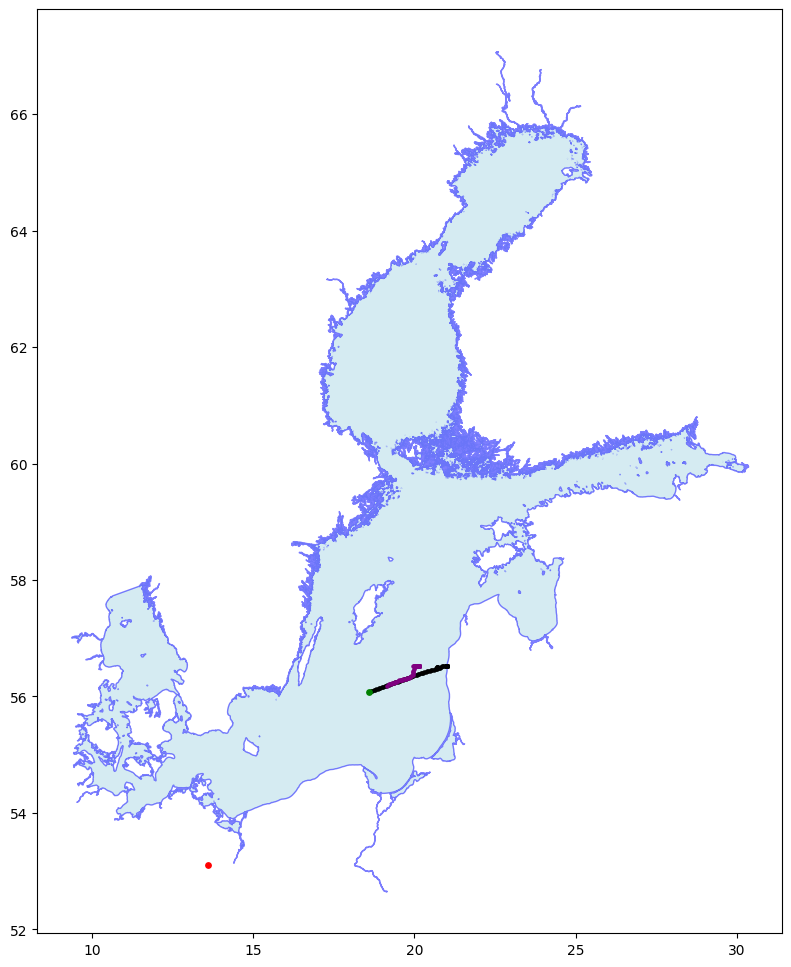

In [31]:
# Ścieżka do katalogu, w którym zapiszemy wykresy
output_dir = "plots/baltic"
os.makedirs(output_dir, exist_ok=True)

# Zakładamy, że test_true_denormalize i test_pred_denormalize to listy/ndarray o tej samej długości
n_samples = len(test_pred_denormalize)

for i in range(n_samples):
    save_path = os.path.join(output_dir, f"trajectory_plot_{i}.png")
    
    # Rysujemy i zapisujemy wykres
    plot_trajectories(
        test_true_denormalize[i],
        test_pred_denormalize[i],
        baltic_gdf,
        LON_MIN, LON_MAX,
        LAT_MIN, LAT_MAX,
        save_path=save_path
    )

    print(f"Zapisano wykres {i} -> {save_path}")

In [37]:
traj

array([[3.88547917e-01, 3.00073136e-01, 4.00000000e-01, 7.08333333e-01,
        2.03963255e-01, 6.00000000e-01, 1.74481733e+09, 5.38003253e+08],
       [3.87404242e-01, 2.95225802e-01, 3.99130750e-01, 7.08333333e-01,
        2.04050904e-01, 6.00000000e-01, 1.74481793e+09, 5.38003253e+08],
       [3.86259090e-01, 2.90410127e-01, 3.97681999e-01, 7.08333333e-01,
        2.04131370e-01, 6.00000000e-01, 1.74481853e+09, 5.38003253e+08],
       [3.85110296e-01, 2.85596496e-01, 3.96233249e-01, 7.08333333e-01,
        6.82362883e-01, 7.00000000e-01, 1.74481913e+09, 5.38003253e+08],
       [3.83957862e-01, 2.80784915e-01, 3.94784498e-01, 7.08333333e-01,
        6.82074076e-01, 7.00000000e-01, 1.74481973e+09, 5.38003253e+08],
       [3.82801791e-01, 2.75975387e-01, 3.93335748e-01, 7.08333333e-01,
        6.81780567e-01, 7.00000000e-01, 1.74482033e+09, 5.38003253e+08],
       [3.81623696e-01, 2.71162431e-01, 3.96730496e-01, 7.06971040e-01,
        2.04406295e-01, 6.00000000e-01, 1.74482093e+09, 5.